# simCLR: A Simple framework for contrastive learning of visual representation
The SimCLR paper, titled "**A Simple Framework for Contrastive Learning of Visual Representations**" was authored by Ting Chen, Simon Kornblith, Mohammad Norouzi, and Geoffrey Hinton. It was first published in March 2020 and has since become influential in the field of deep learning and computer vision.

***original paper link: https://arxiv.org/abs/2002.05709***

## Abstract
SimCLR presents a simple and effective approach to learning powerful visual representations by training on a large dataset without the need for manual labeling or supervision. The core idea behind SimCLR is to maximize the similarity between positive pairs (similar data augmentations of the same image) and minimize the similarity between negative pairs (data augmentations of different images). By doing so, SimCLR encourages the model to learn a semantically meaningful feature space.

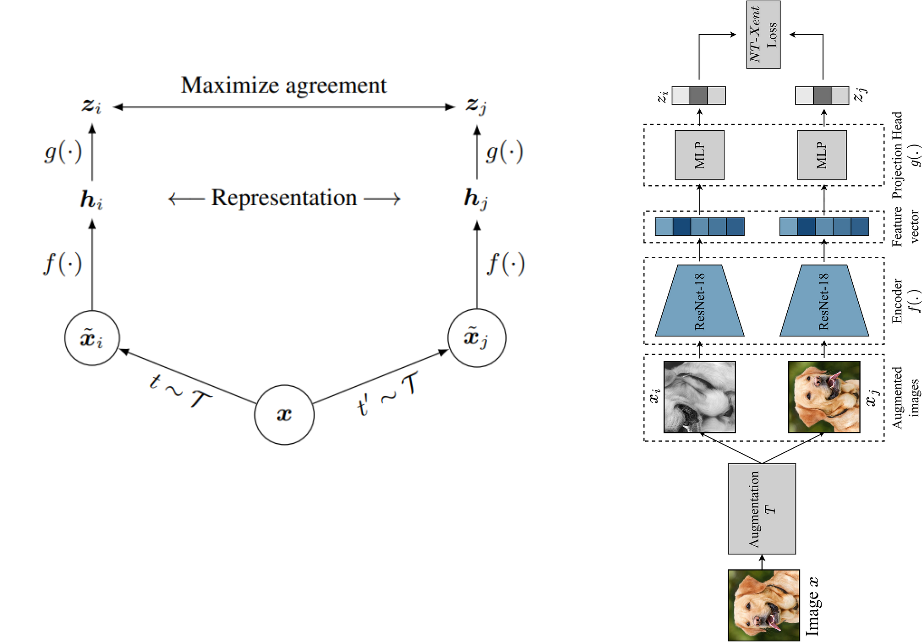

**figure 1: simCLR framework diagram from the original paper (left) and the same digram with more graphical representation (right)**

⚠️ **Declaimer**: I am trying to implement simCLR paper and to verify whether the implementation is done correctly or not, I am going to do model sanity check rather then try to achieve the same level of accuracy that the paper has achieved. The main reason for doing so is due to the lack of computation resources, since to achieve high accuracy we need a large number of dataset and also the computation power. However if you want to run the notebook by yourself and have access to high computation resources you can change the hyper parameter such as BATCH SIZE and SIZE OF THE DATASET by yourself.

# Dataset

The STL-10 dataset is an image recognition dataset for developing unsupervised feature learning, deep learning, self-taught learning algorithms. It is inspired by the CIFAR-10 dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided to learn image models prior to supervised training. The primary challenge is to make use of the unlabeled data (which comes from a similar but different distribution from the labeled data) to build a useful prior. We also expect that the higher resolution of this dataset (96x96) will make it a challenging benchmark for developing more scalable unsupervised learning methods.


***kaggle dataset link: https://www.kaggle.com/datasets/liusha249/stl10set***

***original dataset link: https://cs.stanford.edu/~acoates/stl10/***


# Algorithm
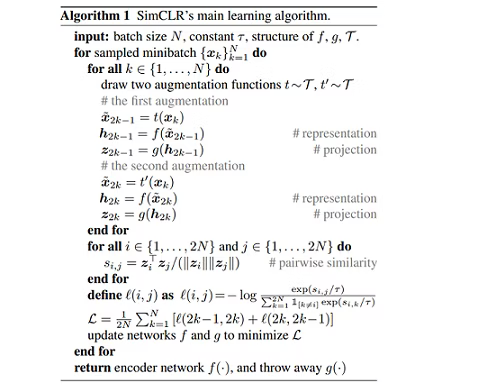

The algorithm is pretty straight forward:
Let's say we have M training examples in total, we divide the entire dataset into K batches of size N.  
- **step 1:** take a single mini-batch of size N from M batches
- **step 2:** apply random transformation(augmentation) functions twice to the mini-batch. As a result, we have 2N total images or two transformed mini-batch, say X' and X.
- **step 3:** pass X' and X through image the encoder (ResNet50 or any CNN architecture) to get H' and H respectively
- **step 3:** now, pass H' and H through the projection function (neural network) to get Z' and Z respectively
- **step 4:** calculate a loss (don't worry I will expain later how to calculate the loss)
- **step 5:** apply optimization techique to update weights
- **step 6:** repeat the same steps from step 1 until K mini-batches are not covered; that would be a single epoch

# Load Dataset
Let's load the dataset first. As you can see datasets are in binary format we can load it using numpy.

We are going to use 2 different datasets for this experiment:
- `unlabeled_X` --contains large number of unlabeled dataset for self-supervised training.
- `train_X` --contains large number of labeled dataset for training downstream task.



In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
UNLABELED_DATA_PATH = "/kaggle/input/stl10set/stl10_binary/unlabeled_X.bin"
IMAGE_SHAPE = (96, 96)
# the dataset contains 100K images, but due to memory constraint, we are only going to take the first 10_000 images.
SAMPLE_SIZE = 10_000 # note that using this much less dataset will overfit the model

Since we have dataset in binary files, we can use numpy to read the binary file.

```
np.fromfile(f,dtype, count).reshape(shape)
```
- **f** = file pointer from where data to be read
- **dtype** = specify the datatype of the element. Make sure you add the same dtype element has before binarization.
- **count** = specify how many elements to be read; for instance, if we want to read two images that have shape (3,3) then the total elements in the array is 2*3*3 = 18, if you set count=-1 then all the elemenent will be read.
- fromfile() reads the binarized data into sequential array (1D array), thus needs to be reshaped into multi-dimensional array for which you can use reshape() method.



In [3]:
# Read file using numpy "fromfile()"
with open(UNLABELED_DATA_PATH, mode='rb') as f:
    # the encoded binarized images is of shape (c, h, w), means "number of channels" dim is in front
    dataset = np.fromfile(f,dtype=np.uint8, count=SAMPLE_SIZE*IMAGE_SHAPE[0]*IMAGE_SHAPE[1]*3).reshape(-1, 3, IMAGE_SHAPE[0], IMAGE_SHAPE[1]) 

# since tf expects image of shape (batch, h, w, c), we have to transpose (batch, c, h, w) into (batch, h, w, c) shape.
np_dataset = np.transpose(dataset, (0, 3, 2, 1))

In [4]:
print("Shape of the dataset: ", np_dataset.shape)

Shape of the dataset:  (10000, 96, 96, 3)


Here, you can see we have 10,000 images of shape (96, 96, 3)

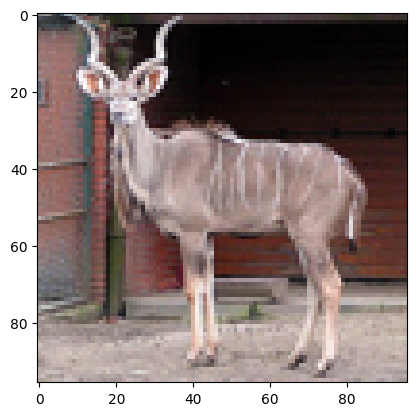

In [5]:
# let's visualize single image from the dataset
plt.imshow(np_dataset[0])

Now, we are going to create a custom function that helps to plot a batch of images in a grid

In [6]:
def display_grid(images, nrows, ncols, figsize):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(nrows, ncols),  # creates nrowsxncols grid of axes
                     axes_pad=0.1,  # pad between axes
                     )

    for ax, im in zip(grid, images[:nrows*ncols]):
        ax.imshow(im)
        ax.axis("off")

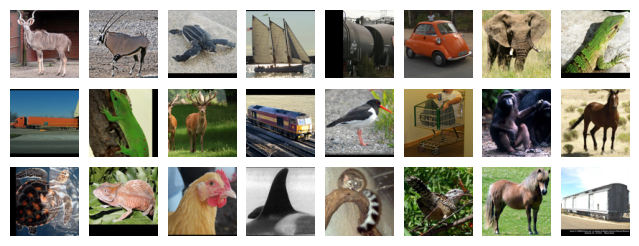

In [7]:
display_grid(np_dataset, 3, 8, figsize=(8, 12))

## Input pipeline

Till now we have a dataset in a np array, to create batches, we are going to use tensorflow input pipeline's API that allows us to transfer numpy array into tensorflow dataset.

In [3]:
import tensorflow as tf

In [9]:
# Create a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((np_dataset))

# batch the dataset
batch_size = 32
dataset = dataset.batch(batch_size, drop_remainder= True)

In [10]:
# testing
for batch in dataset:
    print("mini-batch shape: ", batch.shape)
    break

mini-batch shape:  (32, 96, 96, 3)


Here, you can see, now we have batch of 32 images.

In [11]:
# alternatively; we can also use iter() and next() to extract a single batch from the dataset
# we are going to use this method later.
batch = next(iter(dataset))
print("Min-batch shape: ", batch.shape)

Min-batch shape:  (32, 96, 96, 3)


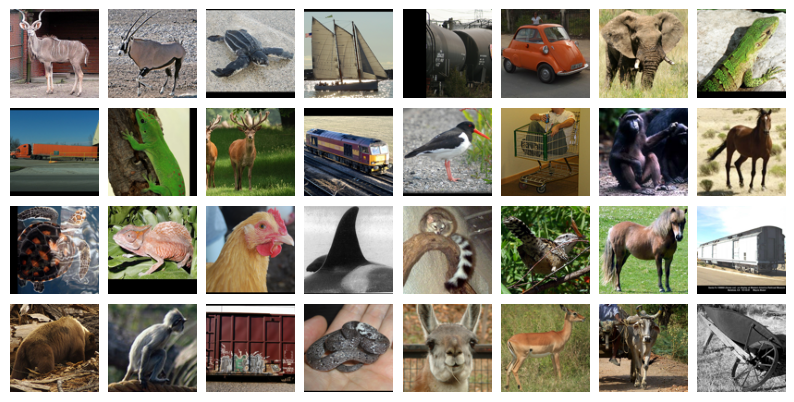

In [12]:
# let's plot a single batch
# we have 32 in a batch, and we are going to have image grid of 4 rows and 8 columns (4*8=32)
display_grid(batch, 4, 8, figsize=(10, 14))

# Data Augmentation

The first component of simCLR is a data augmenter/transformer, that performs color distortion, cropping and reshaping, horizontal flip, etc. 

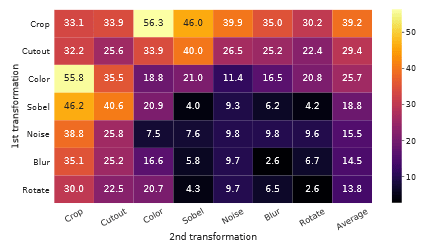
**Figure:** linear evaluation under individual or composition of data augmentation

**Findings**

Authers' have found that
* to achieve quality visual representation augmentation on the both branch is needed
*  it is critical to compose cropping with color distortion in order to learn generalizable features

We are going to stick to the authers' finding, so going to use cropping+resizing with color distortion transformation for data augmentation, for now.

Note that we are going to apply these transformation randomly, and these transformation also take random transformation values. 
For instance, an image will have probability p to get color distortion transformation, and if it gets color distortion, it will be distorted with r random value from the given range.

## Custom Decorator
Building a custom decorator to add randomness to the function call. In pytorch, We can easily apply random transformation using built-in class `RandomApply`, but in tensorflow we have to define it. 

In [13]:
import random

Let's create a custom decorator that applies a given function with a specified probability.

In [15]:
def random_apply(prob="from_obj"):
    """
    Create a decorator that conditionally applies a given function with a specified probability.

    Args:
        prob: A float representing the probability of applying the function. If 'in', the probability
              will be dynamically retrieved from the instance's 'prob' attribute.

    Returns:
        A decorator that applies the wrapped function with a given probability.

    Decorator Usage:
        @random_apply(prob)
        def your_function(image, *args, **kwargs):
        # Your function logic here
    """
    def decorator(func):
        def wrapper(*args, **kwargs):
            prob_ = prob
            if prob=="from_obj":
                prob_ = args[0].prob
            if kwargs.get("images") is not None:
                images = kwargs.get("images") 
            else:
                images = args[-1]
                
#             print("prob:", prob_)
            do_apply = tf.random.uniform(()) < prob_
            return tf.cond(
                do_apply,
                lambda: func(*args, **kwargs),
                lambda: images
            )
        return wrapper
    return decorator

In [16]:
# Testing random_apply decorator
class Test:
    def __init__(self, prob):
        # add global probability to apply the decorated method
        self.prob = prob
    
    # we have set local prob 0.5,
    # thus the chance of applying square to the given value is 50%
    # Note that if we haven't provided the local prob; global prob will be used
    @random_apply(prob=0.5) # local probability will override global probability value
    def square(self, value):
        # returns square of the value 
        return value**2

# creating a Test instance
test = Test(prob=0.8) # instantiating test object with global prob
# we have called the same method thrice, let's see whether we will get its square all the time or not
print("random square: ", test.square(3))
print("random square: ", test.square(3))
print("random square: ", test.square(3))

random square:  3
random square:  3
random square:  9


If you get '9' means the square function is applied to the input value, if '3' than it is not applied.

## Data Augmentor/Tranformer
We are going to create a custom class that applies data transformation randomly to the given batch of image.

In [17]:
class CustomAugmentation:
    def __init__(self, s=1.0, prob=0.5):
        self.s = s
        self.prob = prob
    # we haven't set any local prob this time
    # we are going to use the global prob value for every transformation function
    @random_apply()
    def __random_contrast(self, images):
        return tf.image.random_contrast(images, lower=1 - 0.8 * self.s, upper=1 + 0.8 * self.s)
    
    @random_apply()
    def __random_brightness(self, images):
        return tf.image.random_brightness(images, max_delta=0.8*self.s)
        
    @random_apply()
    def __random_saturation(self, images):
        return tf.image.random_saturation(images, lower=1-0.8*self.s, upper=1+0.8*self.s)
    
    @random_apply()
    def __random_hue(self, images):
        return tf.image.random_hue(images, max_delta=0.2*self.s)
    
    @random_apply(prob=0.5)
    def __random_hflip(self, images):
        return tf.image.flip_left_right(images)
    
    @random_apply(prob=0.5)
    def __random_vflip(self, images):
        return tf.image.flip_up_down(images)
    
    @random_apply()
    def __random_gaussian_noise(self, images):
        noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1, dtype=tf.float32)
        return tf.add(images, noise)
    
    @random_apply()
    def __random_color_distortion(self, images):        
        color_distortion_family = [self.__random_hue, self.__random_saturation,
                                   self.__random_brightness, self.__random_contrast,
                                   self.__random_hflip, self.__random_vflip, 
                                   self.__random_gaussian_noise]
        # shuffle color_distortion family
        random.shuffle(color_distortion_family)
        
        # apply distortion randomly
        for transformation in color_distortion_family:
            # we need to apply transformation to each image separately instead of applying it in a batch at once
            # to get different transformations to different images
            images = tf.map_fn(transformation, images)
        
        return images
    
    @random_apply(prob=1.)
    def __random_crop(self, images):
        original_shape= (images.shape[0], images.shape[1])
        r_crop_shape = random.randint(int(original_shape[0]*(2/5)),
                                     int(original_shape[0]*(3/4)))
        
        images= tf.image.random_crop(
                        images,
                        size=[
                            r_crop_shape,
                            r_crop_shape, 
                            3
                        ]
                )
        images = tf.image.resize(images, original_shape)
        return images
    
    def __random_crop_resize(self, images):        
        # cropped images
        images = tf.map_fn(self.__random_crop, images)   
        return images
    
            
    def __call__(self, images):
        # images = (batch, 96, 96, 3)
        # typecast image into float32 
        images = tf.cast(images, dtype=tf.float32)
        images = self.__random_crop_resize(images=images)
        images = self.__random_color_distortion(images=images)
        return images

In [18]:
# Testing CustomAugmentation
augmentation = CustomAugmentation(prob=0.8) # set global prob =0.8

# if you remember we have two branch in the simCLR framework
# which basically means apply transformation twice, so that each image has a pair in the augmented training batch
# branch 1
aug_images_1 = augmentation(batch)
# brach 2
aug_images_2 = augmentation(batch)

print("Shape of an augmented images batch: ", aug_images_1.shape)

Shape of an augmented images batch:  (32, 96, 96, 3)


Note that after applying tf.image.resize, we get floating point pixel values; if we plot it directly we are going to get an horrible result (washed-out, glitched image).

Explaination: https://stackoverflow.com/questions/46217420/my-picture-after-using-tf-image-resize-images-becomes-horrible-picture
- After applying resize we are going to get pixed values in a floating point, and if `plt.imshow` sees a float values like .5 or 221.3 it clips that into the range[0,1].
- To resolve this issue, we have to type cast pixel values into uint8.

resized image without typecasting pixel value:  tf.Tensor([178. 196. 175. 168. 181.], shape=(5,), dtype=float32)
resized image without typecasting pixel value:  tf.Tensor([178 196 175 168 181], shape=(5,), dtype=uint8)


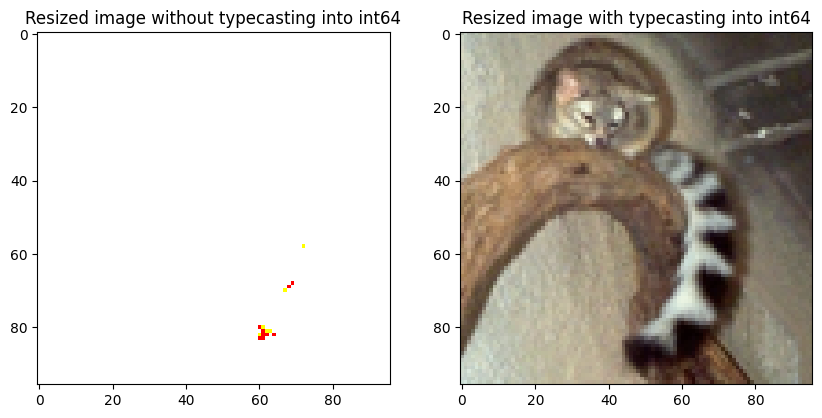

In [19]:
resized_image = tf.image.resize(batch[20], (96, 96))
print("resized image without typecasting pixel value: ", resized_image[0,:5, 0])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# without type casting
axes[0].set_title("Resized image without typecasting into int64")
axes[0].imshow(resized_image)

# after type casting
resized_image_int = tf.cast(resized_image, dtype="uint8")
print("resized image without typecasting pixel value: ", resized_image_int[0, :5, 0])

axes[1].set_title("Resized image with typecasting into int64")
axes[1].imshow(resized_image_int)

Now we are going to plot augmented images after typecasting it.

Augmented images 1 


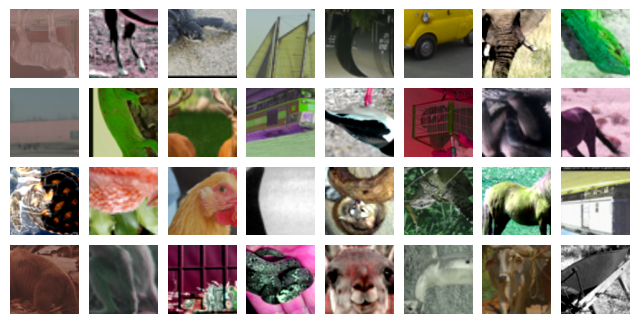

In [20]:
## let's visualize the augmented images
# visualizing augmented branch 1
print("Augmented images 1 ")
int_aug_images_1 =tf.cast(aug_images_1, dtype=np.int64)
display_grid(int_aug_images_1, 4, 8, figsize=(8,12))

Augmented images 2


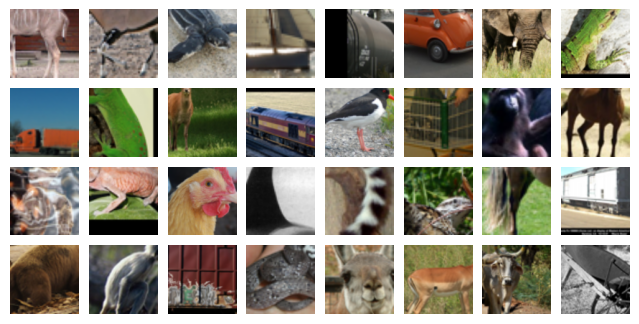

In [21]:
# visualizing augmented branch 2
print("Augmented images 2")
int_aug_images_2 =tf.cast(aug_images_2, dtype=np.int64)
display_grid(int_aug_images_2, 4, 8, figsize=(8,12))

We have successfully created the data augmenter component of simCLR framework. Now let's create image encoder and projection components.
Note that you can add rotation and other transformation also.

# Loss Function
The contrastive loss measures the similarity between two views of an image and tries to maximize the similarity between positive (i.e., two views of the same image) and minimize the similarity between negative (i.e., two views of different images).

The loss function is the main component of the simCLR function, and at first, you will find it quite tricky but once you understand the underlying maths you will find it quite simple. Don't worry, I will try to explain it graphically.


We apply same transformation function twice to the given mini-batch and get two transformed mini-batch.
Let's say we have 2 images in our batch then we get 2N batch of images. For convenience, I have given name to the transformed image i.e 1, 2, A, B
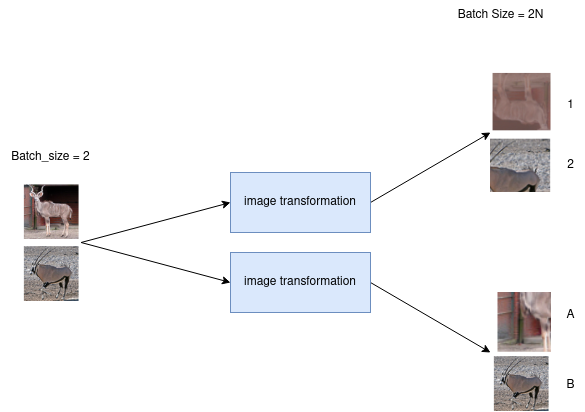

Positive pairs means those elements belongs to the same parent image. And for N images(before transformation), we will have N positive pairs.
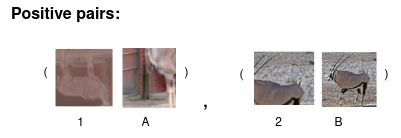


Let's represent negative pairs, since we need to pair each images to every other images in the mini-batch of size 2N, it is better to use matrix to represent it. 
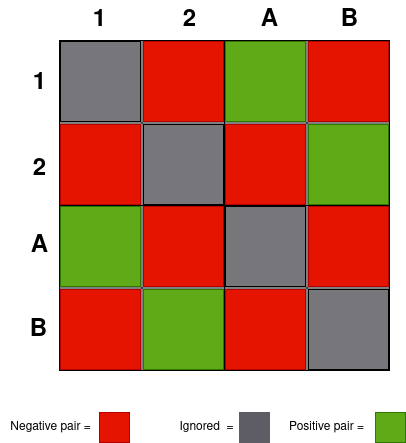


Here you can see, (1,A), (2,B), (A,1) and (B,2) are positive pairs, and (1, 2), (1, B), (2, 1), (2, A), (A, 2), (A, B), (B, 1), (B, A) are the negative pairs. Whereas, we cannot compare a image with itself, thus we will ignore it.

### Cosine similarity

Before getting back into the loss function, we have to understand cosine similarity which measure the similarity between two non-zero vectors.
You will find this formula to calculate cosine similarity if you search on the internet.
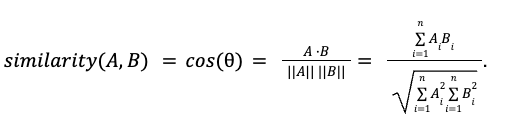

Alternatively, we can calculate it as the product of the vector norms. 
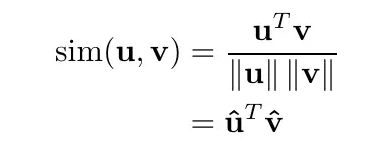

So to calculate the similarity score of the positive pairs we can simply multiple the normalized mini-batch 1 with mini-batch 2.

```python
def cosine_sim(self, vec1, vec2):
        # vec2 = (batch, size_vec)
        # vec2 = (batch, size_vec2)
        # axis = 1; column-wise normalization, since each rows represent each image vector
        norm_vec1 = tf.math.l2_normalize(vec1, axis=1) # vec1 / ||vec1||
        norm_vec2 = tf.math.l2_normalize(vec2, axis=1) # vec2 / ||vec2||
        return norm_vec1 * norm_vec2
```

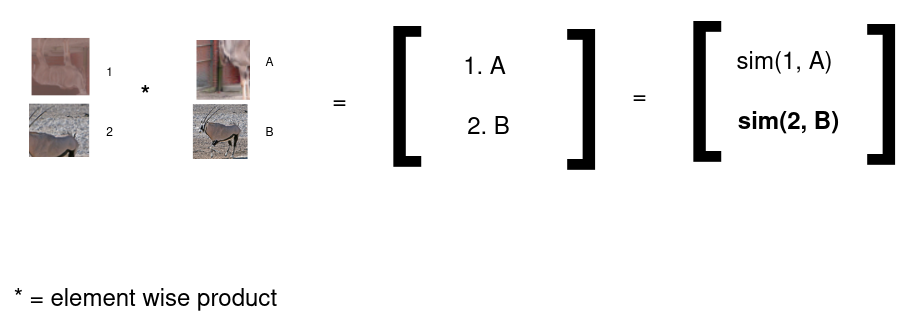

Note that I am using image for conveniance, actually, it is a normalized (l2_normalized) encoded vector of the corresponding image output from the projection layer (MLP).

Now let's calculate the cosine similarity of the negative pairs, we can get this by applying dot product between the 2N mini-batch.
```python
def cosine_sim_score_matrix(self, vec1, vec2):
        # vec2 = (batch, size_vec)
        # vec2 = (batch, size_vec2)
        # axis = 1; column-wise normalization, since each rows represent each image vector
        norm_vec1 = tf.math.l2_normalize(vec1, axis=1) # vec1 / ||vec1||
        norm_vec2 = tf.math.l2_normalize(vec2, axis=1) # vec2 / ||vec2||
        cosine_sim = norm_vec1 @ tf.transpose(norm_vec2)
        return cosine_sim
```

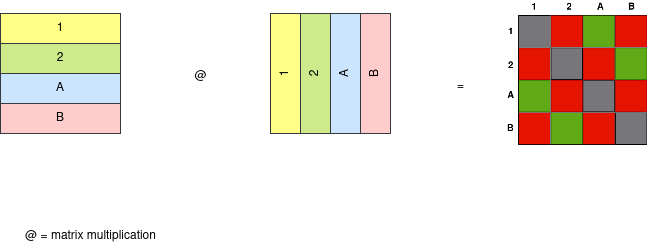

Now, get back into the actual loss function.

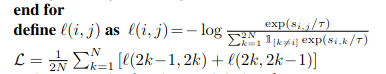

Here, (i, j) are positive pairs.

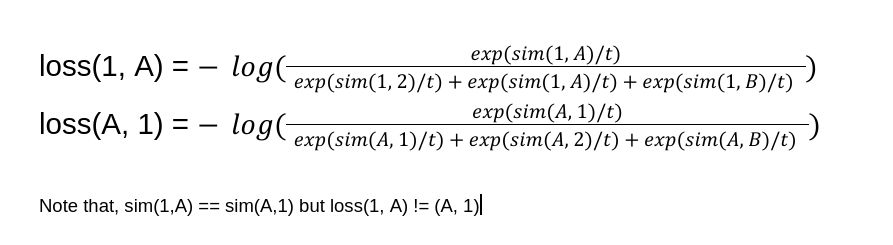

The batch loss is calculated as 
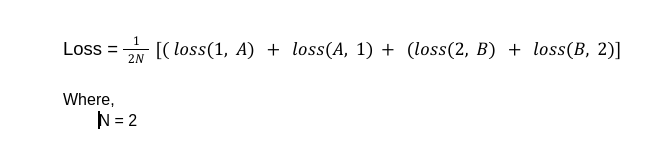

Note that the use of exp() is basically implementation of a softmax function, to convert similarity score into probability.

Now, let's see how we implement this using linear algebra.


Let's first compute the exp(sim()/t) of the positive pairs or say numerators

```python
# calculating sim score for numerator i.e positive pairs
positive_sim_half = self.cosine_sim(zi, zj)
positive_half_by_tau = positive_sim_half / self.temperature
exp_sim_by_tau = tf.math.exp(positive_half_by_tau)
```

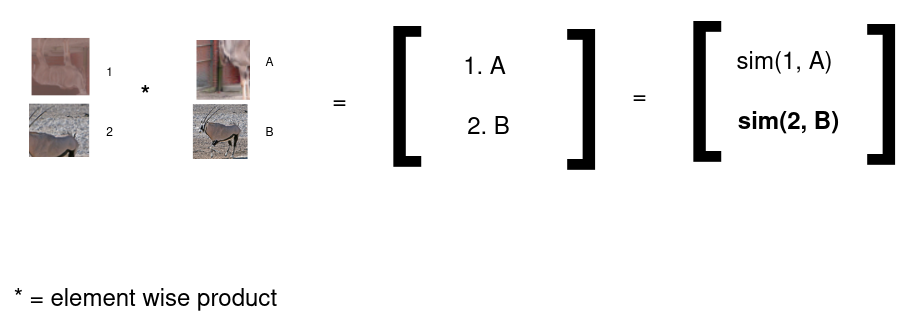

```python
numerators = tf.concat([exp_sim_by_tau, exp_sim_by_tau], axis=0)
```
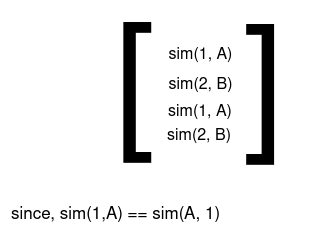

Here, sim() basically means exp(sim()/t). "numerators" is a vector which contains every positive pairs. 

Now, let's compute similarity score of negative pairs or for denominators.
```python
# calculating sim scores for denominator
concat_zij = tf.concat([zi, zj], axis=0)
pairwise_sim_scores = self.cosine_sim_score_matrix(concat_zij, concat_zij)
sim_by_tau = pairwise_sim_scores/self.temperature
exp_sim_by_tau = tf.math.exp(sim_by_tau)

# diagonal values contains sim(i, i) thus remove it
mask_diag = 1- tf.eye(exp_sim_by_tau.shape[0])
exp_sim_by_tau *= mask_diag
```
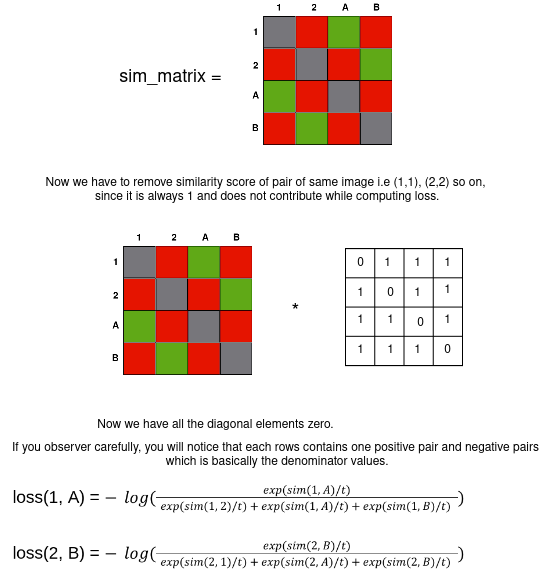

Denominator value contains the sum of elements column-wise. 
```python
# row-wise sum
denominators = tf.math.reduce_sum(exp_sim_by_tau, axis=1, keepdims=True)
```
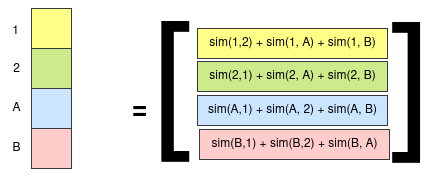

Now, we have denominators and numinators values, in vectors. We can simply divide numerators by denominators and apply -log() we will get loss(1,A), loss(2, B), loss(A, 1) and loss(B,2) and if we average them we get the batch loss.

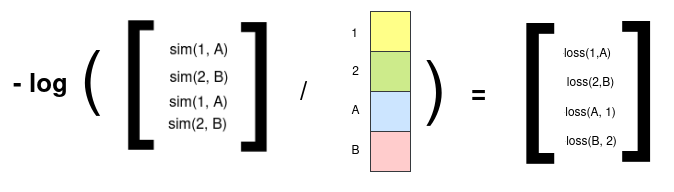

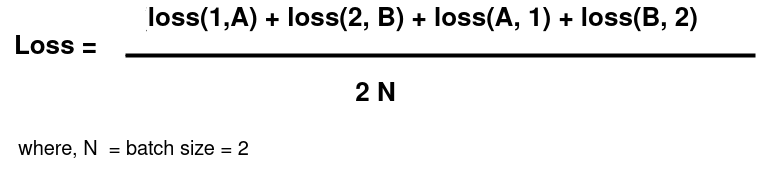

In [1]:
from tensorflow import keras

In [ ]:
class NT_XenLoss(keras.losses.Loss):
    def __init__(self, temperature=0.1, name="contrastive_loss"):
        super().__init__(name=name)
        self.temperature = temperature
    
    def cosine_sim_score_matrix(self, vec1, vec2):
        norm_vec1 = tf.math.l2_normalize(vec1, axis=1) # vec1 / ||vec1||
        norm_vec2 = tf.math.l2_normalize(vec2, axis=1) # vec2 / ||vec2||
        cosine_sim = norm_vec1 @ tf.transpose(norm_vec2)
        return cosine_sim
    
    def cosine_sim(self, vec1, vec2):
        # vec2 = (batch, size_vec)
        # vec2 = (batch, size_vec2)
        norm_vec1 = tf.math.l2_normalize(vec1, axis=1) # vec1 / ||vec1||
        norm_vec2 = tf.math.l2_normalize(vec2, axis=1) # vec2 / ||vec2||
        return norm_vec1 * norm_vec2
    
    def call(self, zi, zj):
        # zi = (Batch, vec_dim)
        # calculating sim score for numerator i.e positive pairs
        positive_sim_half = self.cosine_sim(zi, zj)
        positive_half_by_tau = positive_sim_half / self.temperature
        exp_sim_by_tau = tf.math.exp(positive_half_by_tau)
        numerators = tf.concat([exp_sim_by_tau, exp_sim_by_tau], axis=0)
        
        # calculating sim scores for denominator
        concat_zij = tf.concat([zi, zj], axis=0)
        pairwise_sim_scores = self.cosine_sim_score_matrix(concat_zij, concat_zij)
        sim_by_tau = pairwise_sim_scores/self.temperature
        
        exp_sim_by_tau = tf.math.exp(sim_by_tau)
#         print(exp_sim_by_tau)
#         print(exp_sim_by_tau)
        # diagonal values contains sim(i, i) thus remove it
        mask_diag = 1- tf.eye(exp_sim_by_tau.shape[0])
        exp_sim_by_tau *= mask_diag
        # row-wise sum
        denominators = tf.math.reduce_sum(exp_sim_by_tau, axis=1, keepdims=True)
        
        # calculate losses
        losses = - tf.math.log(tf.math.divide(numerators, denominators))
    
        # average loss
        batch_loss = tf.math.reduce_mean(losses, axis=0)
        
        return batch_loss

In [92]:
# Testing loss function
vec1 = [[1., 0, 0],
        [0, 1, 0]]
vec2 = [[0., 1, 0],
        [1., 0, 0]]

contrastive_loss = NT_XenLoss(temperature=0.8)

In [93]:
# minimum possible loss value
contrastive_loss(vec1, vec1)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2863241>

In [94]:
# maximum possible loss value
contrastive_loss(vec1, vec2)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7029909>

Note that, with this loss function we cannot have minimum loss value 0.

In [11]:
print("loss when model is 100% correct: ", -tf.math.log(tf.exp(1.)/ (tf.exp(1.)+tf.exp(0.)+tf.exp(0.))))

loss when model is 100% correct:  tf.Tensor(0.55144477, shape=(), dtype=float32)


With different tenperature value this value even fluctuates.

# Building Model

We will be using ResNet50 as an image encoder, you can test it with different CNN architecture.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [163]:
# define simCLR framework
class simCLR_ResNet(models.Model):
    def __init__(self, input_shape, hidden_layers_dim, activation):
        super().__init__()

        # for representation layers block
        # using resnet50 without pretrained weight, since simCLR is going to pretrain it
        self.base_resnet = tf.keras.applications.ResNet50(include_top=False,
                                                          weights=None,
                                                          input_tensor=None,
                                                          input_shape=input_shape,
                                                          pooling='avg')
     
        self.base_resnet.trainable = True
        
        # for projection layers block
        self.proj_hidden_layers = [(layers.Dense(h_size, activation=None),
                                    layers.BatchNormalization(),
                                    layers.Activation(activation)) for h_size in hidden_layers_dim[:-1]]
        self.proj_out = layers.Dense(hidden_layers_dim[-1], activation=None)
#         self.proj_out_norm = layers.LayerNormalization()
    
    def get_encoder(self):
        input_ = self.inputs_
        output_ = self.base_resnet50.layers[-1].output
        return models.Model(input_, output_, name="encoder")
    
    def call(self, inputs):
        # define framework
        # representation block
        x = self.base_resnet(inputs)
        for proj_layer, batch_norm, activation in self.proj_hidden_layers:
            x = proj_layer(x)
            x = batch_norm(x)
            x = activation(x)

        x = self.proj_out(x)
#         x  = self.proj_out_norm(x)
        return x
    # overriding compile methods
    def compile(self, optimizer, loss_fn, data_aug, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.aug = data_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    
    # overriding train_step    
    def train_step(self, batch):
#         print("\n", batch[0][0][0])
        xi = self.aug(batch)
        xj = self.aug(batch)
#         print("\n", xi[0][0][0])
        # xi (BATCH, vec_dim)
        with tf.GradientTape() as tape:
            zi = self(xi)
            zj = self(xj)

            loss = self.loss_fn(zi, zj)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
        self.optimizer.apply_gradients(zip(clipped_gradients, self.trainable_variables))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    @property
    def metrics(self):
        return [self.loss_tracker]


# Model training

let's train the model.

In [164]:
# Create a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((np_dataset))
# batch the dataset
batch_size = 256
dataset = dataset.batch(batch_size, drop_remainder= True)

In [ ]:
# model configuration
augmentor = CustomAugmentation(prob=0.95)
model  = simCLR_ResNet((96, 96, 3), [128], "relu")
loss_fn = NT_XenLoss(temperature=0.5)

lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.5)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_scheduler)

In [166]:
model.compile(optimizer, loss_fn, augmentor)

In [167]:
histories = []

In [7]:
! pip install plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 6.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9457 sha256=a1cdc1e4fa820105ab77e10ff074e87d0fb8d1087618965613bd1eff5b6f2084
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320501 sha256=71004a9ab39737b10897283ed657d97f7549bdba7fa8e8b2f57494bc9041f00f
  Stored in directory: /root/.cache/pip/wheels/b7/f3/5d/748143833c99806921d4e1182c248876b83464746ef1e46f1d
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=8c15538b8e3fec48f9c925a09288b14a745cd238d0a4b5d1de374779696567d0
  Stored in

In [8]:
from plot_keras_history import plot_history, chain_histories

In [168]:
# If you want to check the gradient values the set this True 
# and you can print the gradients
tf.config.experimental_run_functions_eagerly(False)

Epoch 1/2
39/39 [==============================] - 171s 3s/step - loss: 7.7607
Epoch 2/2
39/39 [==============================] - 98s 3s/step - loss: 7.4060


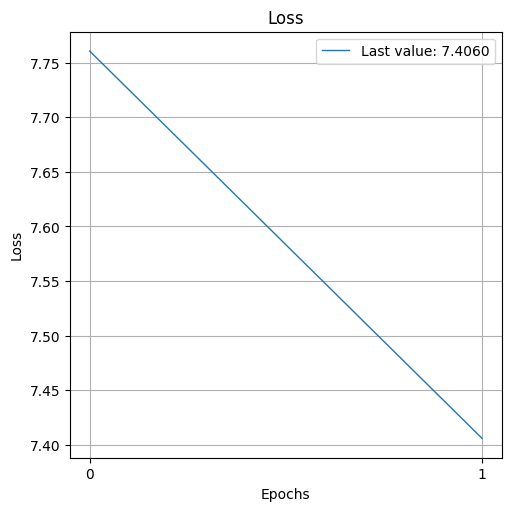

In [169]:
hist = model.fit(dataset, epochs=2, verbose=1)
plot_history(hist)
histories.append(hist)

Epoch 1/50
39/39 [==============================] - 97s 3s/step - loss: 7.1870
Epoch 2/50
39/39 [==============================] - 98s 3s/step - loss: 7.0081
Epoch 3/50
39/39 [==============================] - 99s 3s/step - loss: 6.8633
Epoch 4/50
39/39 [==============================] - 98s 2s/step - loss: 6.7945
Epoch 5/50
39/39 [==============================] - 100s 3s/step - loss: 6.7094
Epoch 6/50
39/39 [==============================] - 98s 3s/step - loss: 6.6862
Epoch 7/50
39/39 [==============================] - 101s 3s/step - loss: 6.6296
Epoch 8/50
39/39 [==============================] - 99s 3s/step - loss: 6.5986
Epoch 9/50
39/39 [==============================] - 96s 2s/step - loss: 6.5783
Epoch 10/50
39/39 [==============================] - 96s 2s/step - loss: 6.5476
Epoch 11/50
39/39 [==============================] - 97s 2s/step - loss: 6.5270
Epoch 12/50
39/39 [==============================] - 96s 2s/step - loss: 6.5054
Epoch 13/50
39/39 [============================

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>)

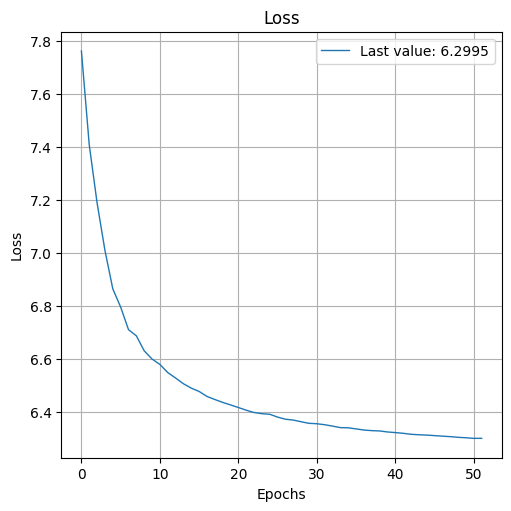

In [170]:
# more training
hist = model.fit(dataset, epochs=50, verbose=1)
histories.append(hist)
plot_history(chain_histories(*histories))

The loss curve is pretty smooth, I think it is the case of overfitting because in the original paper it took a while to train the model.

In [ ]:
# hist = model.fit(dataset, epochs=50, verbose=1)
# histories.append(hist)
# plot_history(chain_histories(*histories))

## Save model
let's save the model so that we do not have to re-train it again. We are going to need the pretrained ResNet to evaluate the simCLR on the downsteam classification task.

In [171]:
# Save model
model.save('my_model_new_1')

Since the model is saved in the kaggle session, we have to download it locally else we are going to lose it. 

In [172]:
import os
import subprocess
from IPython.display import FileLink, display

# this function will compress the model dir into zip
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [173]:
download_file("/kaggle/working/my_model_new_1", "simCLR_epoch50")

/kaggle/working/simCLR_epoch50.zip

# Load saved model
At first we need to upload the locally saved model into kaggle. You can do that by clicking \[+Add Data\]

In [9]:
import tensorflow as tf

In [10]:
model = tf.keras.models.load_model("/kaggle/input/simclr-checkpoints/kaggle/working/my_model_new_1")

# Downstream Task

> a "downstream task" refers to a task or application that comes after or is built upon the results of a preceding task.

we are going to perform classification task using pretrain ResNet50.

In [12]:
# get the pretrained resnet50
pretrained_resnet = model.base_resnet

In [175]:
# pretrained_resnet.summary()

In [13]:
# freeze pretrained resnet
for layer in pretrained_resnet.layers:
    layer.trainable = False

In [14]:
# verifying freezing pretrained resnet is successful
pretrained_resnet.trainable_variables

[]

## Loading train and test dataset

source code ref: https://github.com/mttk/STL10/blob/master/stl10_input.py 

- 10 classes
- 800 test images per class.

### Load class names

In [15]:
# read class names
with open("/kaggle/input/stl10set/stl10_binary/class_names.txt") as f:
    class_names = f.readlines()
    
class_names = [name.strip() for name in class_names]

In [16]:
class_names

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

### Load labels (train_y and test_y)

In [4]:
def read_labels(file_path):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(file_path, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [5]:
train_y = read_labels("/kaggle/input/stl10set/stl10_binary/train_y.bin")
test_y = read_labels("/kaggle/input/stl10set/stl10_binary/test_y.bin")

train_y.shape, test_y.shape

((5000,), (8000,))

In [6]:
# let's check how many labels are there
np.unique(train_y), np.unique(test_y)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

We have 10 classes ranging from 1 to 10. But note that sparse_categorical_crossentropy expects labels starting from 0. So let's decrease the lable by 1.

In [7]:
train_y = train_y - 1
test_y = test_y - 1

In [8]:
# let's check how many labels are there
np.unique(train_y), np.unique(test_y)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

Now we have our labels ready.

### load images (train_x and test_x)
Similarly, let's load images

In [21]:
IMAGE_SHAPE = (96, 96, 3)

In [22]:
def read_bin_images(file_path):
    # Read file using numpy fromfile()"
    with open(file_path, mode='rb') as f:
        dataset = np.fromfile(f,dtype=np.uint8, count=-1).reshape(-1, 3, IMAGE_SHAPE[0], IMAGE_SHAPE[1])
    np_dataset = np.transpose(dataset, (0, 3, 2, 1))
    return np_dataset

In [23]:
train_x = read_bin_images("/kaggle/input/stl10set/stl10_binary/train_X.bin")
test_x = read_bin_images("/kaggle/input/stl10set/stl10_binary/test_X.bin")

train_x.shape, test_x.shape

((5000, 96, 96, 3), (8000, 96, 96, 3))

In [24]:
test_size = 100
test_x, test_y = test_x[:test_size], test_y[:test_size] -1

In [25]:
print("train X size: ", train_x.shape)
print("test X size: ", test_x.shape)

print("train Y size: ", train_y.shape)
print("test Y size: ", test_y.shape)

train X size:  (5000, 96, 96, 3)
test X size:  (100, 96, 96, 3)
train Y size:  (5000,)
test Y size:  (100,)


## build classifier

In [26]:
from tensorflow.keras.regularizers import l2

In [51]:
classifier = tf.keras.Sequential([
        pretrained_resnet,
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation="softmax")
])

In [52]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 23,858,890
Trainable params: 271,178
Non

In [53]:
# Example of using gradient clipping and a learning rate schedule
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [54]:
classifier.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

## Train the classifier

In [55]:
classifier.predict(train_x[:1])

1/1 [==============================] - 1s 1s/step


array([[0.15394692, 0.10689725, 0.07471428, 0.10735779, 0.09814943,
        0.09312009, 0.07559342, 0.12630132, 0.07930696, 0.08461254]],
      dtype=float32)

In [56]:
train_y[:2]

array([1, 5], dtype=uint8)

In [57]:
hist = classifier.fit(train_x, train_y, validation_split=0.3, epochs=2, batch_size=64)

Epoch 1/2
55/55 [==============================] - 9s 92ms/step - loss: 3.3336 - accuracy: 0.1426 - val_loss: 2.3254 - val_accuracy: 0.2293
Epoch 2/2
55/55 [==============================] - 4s 65ms/step - loss: 2.2300 - accuracy: 0.1951 - val_loss: 2.1415 - val_accuracy: 0.2060


In [58]:
histories = [hist]

In [59]:
hist = classifier.fit(train_x, train_y, validation_split=0.3, epochs=5, batch_size=64)
histories.append(hist)

Epoch 1/5
55/55 [==============================] - 4s 78ms/step - loss: 2.1546 - accuracy: 0.1914 - val_loss: 2.0464 - val_accuracy: 0.2220
Epoch 2/5
55/55 [==============================] - 4s 66ms/step - loss: 2.0625 - accuracy: 0.2086 - val_loss: 2.0075 - val_accuracy: 0.2313
Epoch 3/5
55/55 [==============================] - 4s 66ms/step - loss: 1.9907 - accuracy: 0.2223 - val_loss: 1.9397 - val_accuracy: 0.2367
Epoch 4/5
55/55 [==============================] - 3s 59ms/step - loss: 1.9560 - accuracy: 0.2357 - val_loss: 1.8918 - val_accuracy: 0.2600
Epoch 5/5
55/55 [==============================] - 3s 59ms/step - loss: 1.9381 - accuracy: 0.2277 - val_loss: 1.8469 - val_accuracy: 0.2627


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

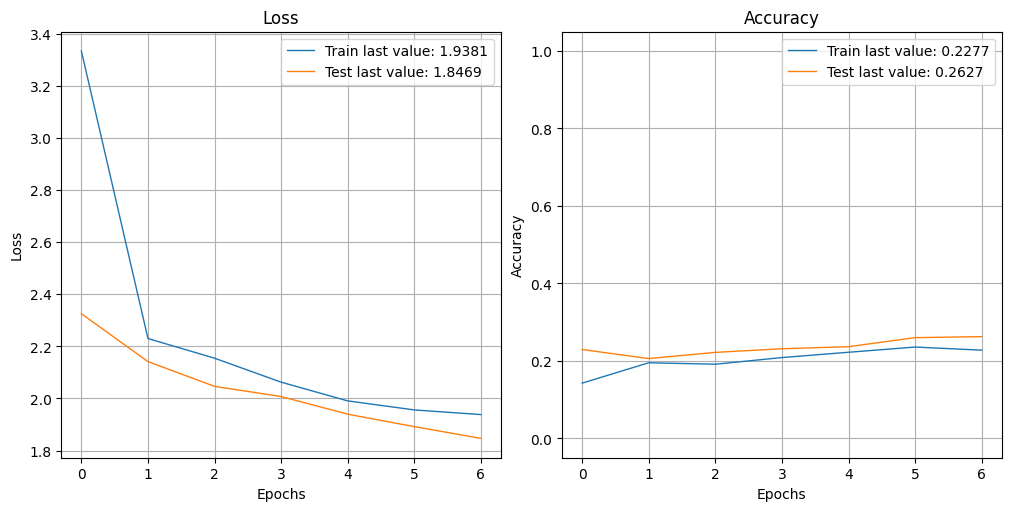

In [60]:
plot_history(chain_histories(*histories))

Epoch 1/15
55/55 [==============================] - 4s 65ms/step - loss: 1.7090 - accuracy: 0.2963 - val_loss: 1.7733 - val_accuracy: 0.2707
Epoch 2/15
55/55 [==============================] - 3s 62ms/step - loss: 1.7833 - accuracy: 0.2697 - val_loss: 1.7961 - val_accuracy: 0.2640
Epoch 3/15
55/55 [==============================] - 4s 66ms/step - loss: 1.7252 - accuracy: 0.2903 - val_loss: 1.7803 - val_accuracy: 0.2820
Epoch 4/15
55/55 [==============================] - 3s 60ms/step - loss: 1.7586 - accuracy: 0.2900 - val_loss: 1.8394 - val_accuracy: 0.2753
Epoch 5/15
55/55 [==============================] - 3s 60ms/step - loss: 1.7157 - accuracy: 0.3017 - val_loss: 1.7822 - val_accuracy: 0.2767
Epoch 6/15
55/55 [==============================] - 4s 67ms/step - loss: 1.7471 - accuracy: 0.2746 - val_loss: 1.7908 - val_accuracy: 0.2680
Epoch 7/15
55/55 [==============================] - 4s 68ms/step - loss: 1.7157 - accuracy: 0.2994 - val_loss: 1.7781 - val_accuracy: 0.2813
Epoch 8/15
55

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

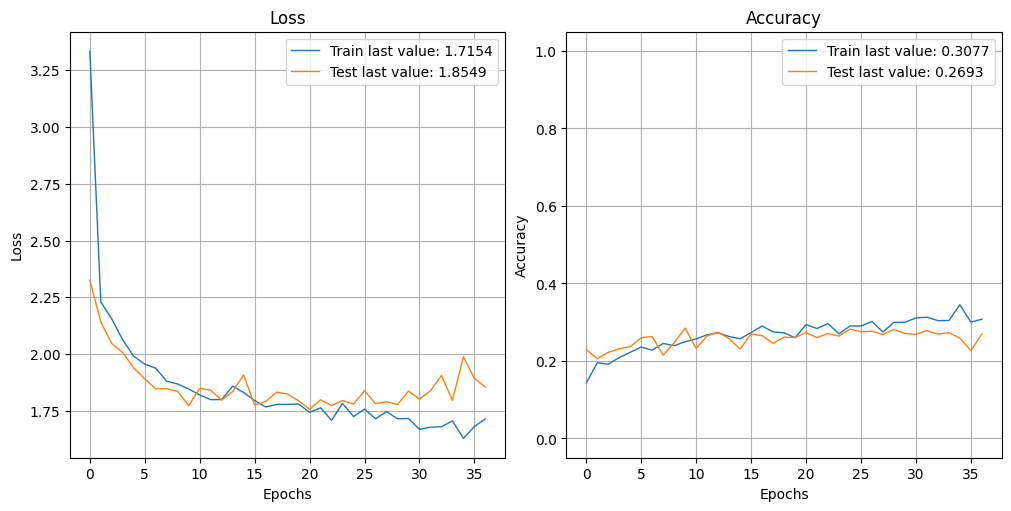

In [62]:
hist = classifier.fit(train_x, train_y, validation_split=0.3, epochs=15, batch_size=64)
histories.append(hist)
plot_history(chain_histories(*histories))

Epoch 1/15
55/55 [==============================] - 4s 71ms/step - loss: 1.6334 - accuracy: 0.3374 - val_loss: 1.9720 - val_accuracy: 0.2787
Epoch 2/15
55/55 [==============================] - 4s 67ms/step - loss: 1.5979 - accuracy: 0.3466 - val_loss: 1.9195 - val_accuracy: 0.2807
Epoch 3/15
55/55 [==============================] - 4s 69ms/step - loss: 1.5924 - accuracy: 0.3460 - val_loss: 1.9279 - val_accuracy: 0.2440
Epoch 4/15
55/55 [==============================] - 4s 70ms/step - loss: 1.6899 - accuracy: 0.3163 - val_loss: 1.8950 - val_accuracy: 0.2707
Epoch 5/15
55/55 [==============================] - 4s 67ms/step - loss: 1.6158 - accuracy: 0.3346 - val_loss: 1.9986 - val_accuracy: 0.2960
Epoch 6/15
55/55 [==============================] - 4s 67ms/step - loss: 1.5894 - accuracy: 0.3569 - val_loss: 1.8232 - val_accuracy: 0.2733
Epoch 7/15
55/55 [==============================] - 4s 67ms/step - loss: 1.5916 - accuracy: 0.3429 - val_loss: 2.0813 - val_accuracy: 0.2607
Epoch 8/15
55

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

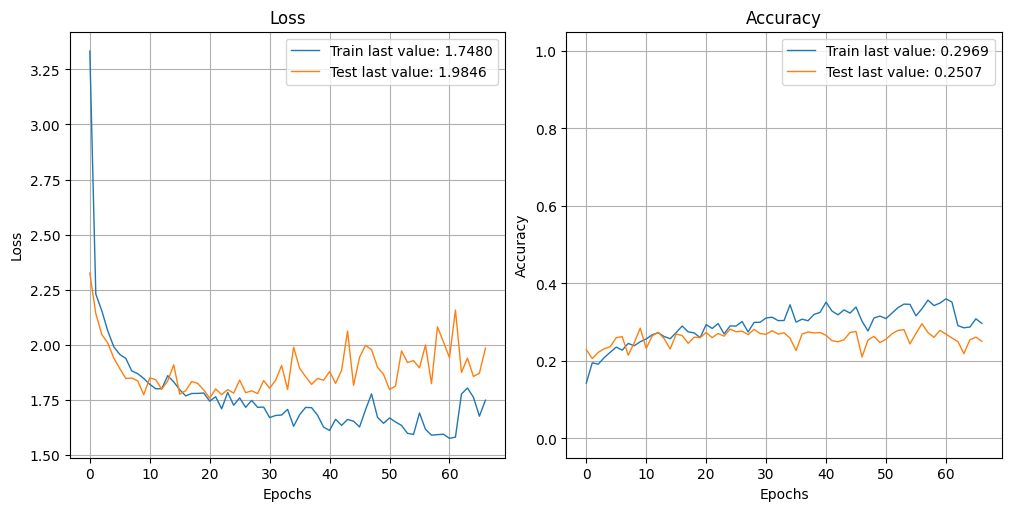

In [65]:
hist = classifier.fit(train_x, train_y, validation_split=0.3, epochs=15, batch_size=64)
histories.append(hist)
plot_history(chain_histories(*histories))

If you want to evaluate the classifier with test data you can. But since we don't have that much high accuracy we are not going to test it with test dataset.

## Conclusion
We have achieved about 30% of accuracy without finetuning and hyperparameter tuning, which is I guess pretty good result.

# t-SNE visualization
t-SNE is a non-linear dimensionality reduction technique unlike PCA it can handle non-linear dataset more accurately. It can be used to visualize the layers output to see whether the layers being able to cluster data into their respective groups.

In [164]:
from sklearn.manifold import TSNE
import seaborn as sns

In [91]:
class_names

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

In [206]:
def extract_feature_label(dataset, model, n_batch=2):
     """
    Extract feature representations from the dataset using the provided model.

    Parameters:
        dataset (tf.data.Dataset): The dataset containing image and label batches.
        model (tf.keras.Model): The neural network model used for feature extraction.
        n_batch (int, optional): The number of batches to process from the dataset. Defaults to 2.

    Returns:
        tuple: A tuple containing the following:
            - features (numpy.ndarray): NumPy array of extracted features.
            - labels_index (numpy.ndarray): NumPy array of label indices.
            - labels (numpy.ndarray): NumPy array of label names corresponding to label indices.
    """
    features = []
    labels_index = []
    labels = []
    for count, mini_batch in enumerate(dataset):
        image_batch, label_batch = mini_batch
        image_batch = tf.cast(image_batch, dtype="float32")
        # get the feature map/ vector embedding
        batch_features = model.predict(image_batch)
        
        features.extend(batch_features)
        labels_index.extend(label_batch)
        labels.extend([class_names[label] for label in label_batch])
        if count+1 == n_batch:
            break

    # Convert the list of features to a NumPy array
    features = np.array(features)
    labels = np.array(labels)
    labels_index = np.array(np.array)
    return features, labels_index, labels

def plot_2d_tsne(features, labels):
    """
    Plot a 2D t-SNE visualization of feature embeddings with labeled data points.

    Parameters:
        features (numpy.ndarray): Feature embeddings to visualize in 2D.
        labels (list or numpy.ndarray): Labels or categories corresponding to the data points.

    Returns:
        None
    """
    # reduct dimension of the features (feature vector)
    # you can change the perplexity value to get more better result
    tsne_embeddings = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=2).fit_transform(features)
    
    # Visualize the t-SNE embeddings
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x= tsne_embeddings[:, 0], y= tsne_embeddings[:, 1], hue=labels)
    plt.title('t-SNE Visualization')
    plt.show()

In [207]:
t_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# # batch the dataset
batch_size = 50
t_dataset = t_dataset.batch(batch_size, drop_remainder= True)

## t-SNE of base_resnet
let's visualize our pretrained model

In [208]:
features, labels_index, labels = extract_feature_label(t_dataset, pretrained_resnet, n_batch=4)
features.shape, labels.shape

2/2 [==============================] - 0s 50ms/step


((200, 2048), (200,))

In [209]:
labels[:5]

array(['bird', 'dog', 'bird', 'horse', 'cat'], dtype='<U8')

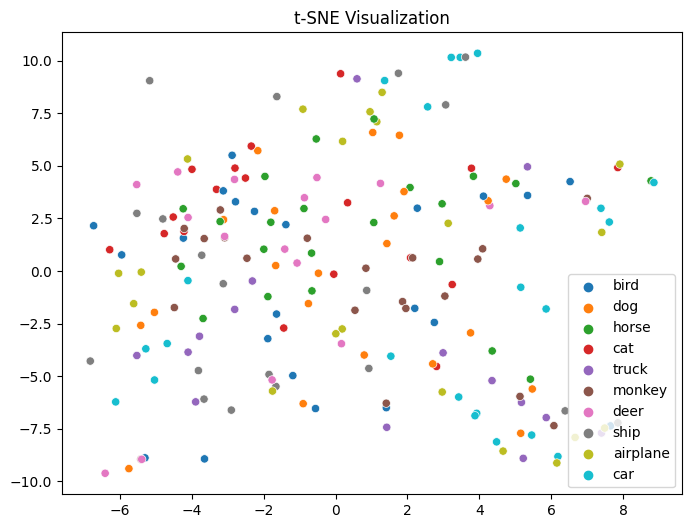

In [210]:
plot_2d_tsne(features, labels)

It seems bad, may be because our pretrained model has not learn anything about how to cluster the similar images, since it is trained to extract feature map. 

## t-SNE visualization of a classifier
Now let's see how our classifier is working. For this we are going to use the output of the second last layer as a feature vector for t-sne visualization. Note that last layer is the classification layer which classifies the vector embedding into one of the given class and thus doesn't carry out the embedding property. 

In [211]:
feature_extractor = tf.keras.Model(inputs=classifier.input, outputs=classifier.layers[-1].output)
feature_extractor.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_input (InputLayer)  [(None, 96, 96, 3)]      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                650 

In [212]:
features, labels_index, labels = extract_feature_label(t_dataset, feature_extractor, n_batch=4)
features.shape, labels.shape

2/2 [==============================] - 0s 31ms/step


((200, 10), (200,))

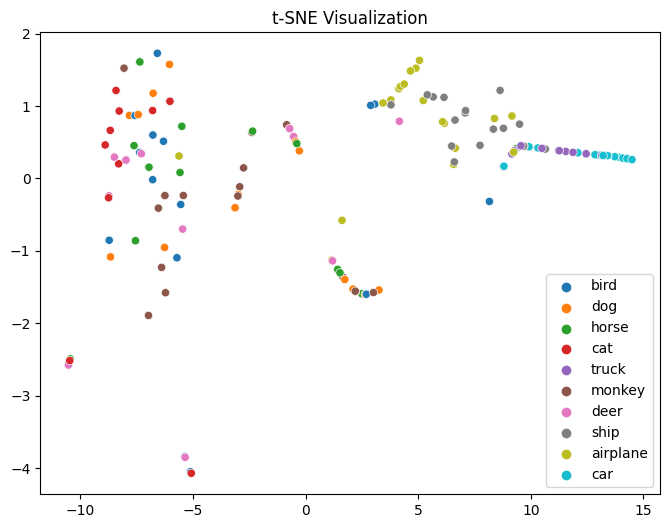

In [213]:
plot_2d_tsne(features, labels)

Okay, it looks better than previous one. You can see our model have clustered bird, airplane and ship more accurately.

## t-SNE visualization pretrained simCLR upto projection
We can also visualize the projection embedding features.But since the projection layer was trained find the similarity between positive pairs, it does not carry any classifier property. Thus, we might not see any cluster in t-SNE visualization. 

In [214]:
model.summary()

Model: "sim_clr__res_net_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_14 (Dense)            multiple                  262272    
                                                                 
 layer_normalization_12 (Lay  multiple                 0         
 erNormalization)                                                
                                                                 
Total params: 23,849,986
Trainable params: 262,272
Non-trainable params: 23,587,714
_________________________________________________________________


In [215]:
features, labels_index, labels = extract_feature_label(t_dataset, model, n_batch=4)

2/2 [==============================] - 0s 34ms/step


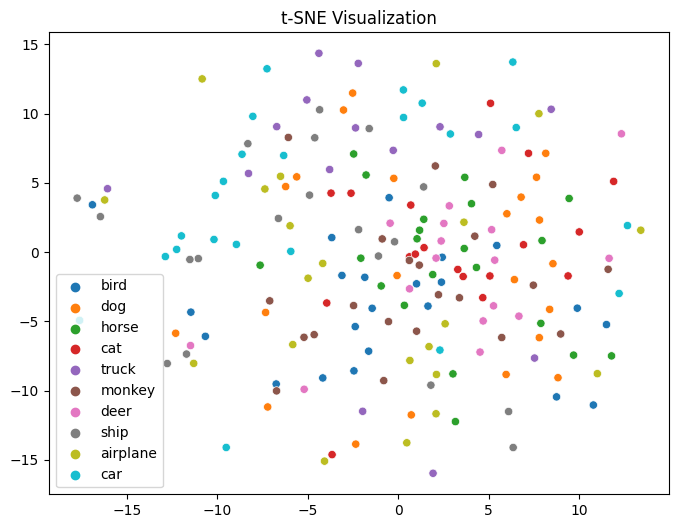

In [216]:
plot_2d_tsne(features, labels)

As expected, there is no clusters.

# Conclusion

We have successfully implemented the simCLR paper and checked the sanity test as well as we used the pretrained model (visual representation) in the downstream task, and understood how to visualize the t-SNE plot to explain model's ability to extract the patterns in the data.